1. Install & Import Required Libraries

In [1]:
!pip install -q librosa kagglehub tensorflow scikit-learn matplotlib seaborn

import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models
import kagglehub


 2. Download GTZAN Dataset from KaggleHub & Check Files

In [2]:
# 📥 Download GTZAN from KaggleHub
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")
print("📂 Dataset path:", path)

# Main data folder
data_path = os.path.join(path, "Data")

# Check files available
print("\n📁 Files in Data folder:")
print(os.listdir(data_path))


📂 Dataset path: /kaggle/input/gtzan-dataset-music-genre-classification

📁 Files in Data folder:
['features_3_sec.csv', 'features_30_sec.csv', 'images_original', 'genres_original']


3. Load 30‑Second Features CSV

In [5]:
# Load the 30-second feature file
features_path = os.path.join(data_path, "features_30_sec.csv")
df_features = pd.read_csv(features_path)

print("✅ Shape:", df_features.shape)
df_features.head()


✅ Shape: (1000, 60)


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


4. Preprocess Data – Encode Labels, Scale Features & Train/Test Split

In [6]:
# Target label column
target_col = "label"

# Encode labels
le = LabelEncoder()
df_features[target_col] = le.fit_transform(df_features[target_col])

# Drop non-feature columns
X = df_features.drop(columns=["filename", target_col])
y = df_features[target_col]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


5. Train RandomForest Model & Evaluate with Confusion Matrix

📊 Classification Report:
              precision    recall  f1-score   support

       blues       0.83      0.75      0.79        20
   classical       0.83      0.95      0.88        20
     country       0.70      0.80      0.74        20
       disco       0.75      0.60      0.67        20
      hiphop       0.67      0.80      0.73        20
        jazz       0.76      0.80      0.78        20
       metal       0.89      0.85      0.87        20
         pop       0.85      0.85      0.85        20
      reggae       0.76      0.80      0.78        20
        rock       0.80      0.60      0.69        20

    accuracy                           0.78       200
   macro avg       0.78      0.78      0.78       200
weighted avg       0.78      0.78      0.78       200



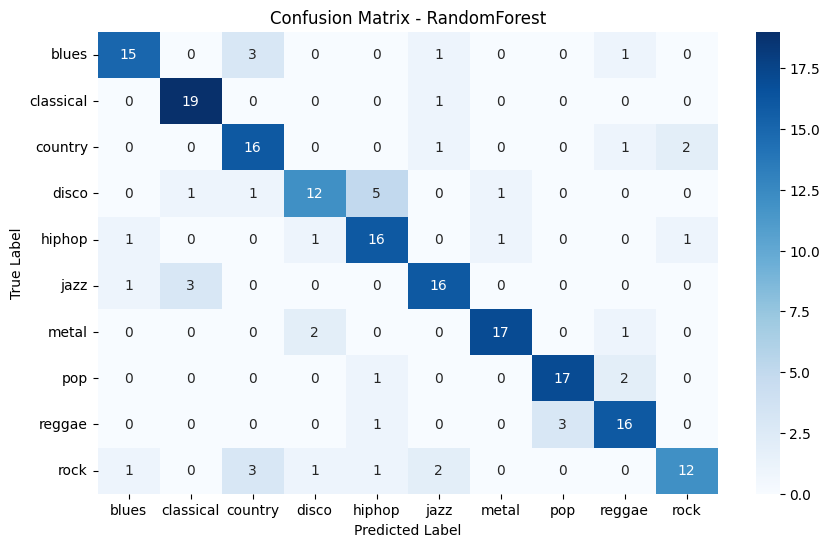

In [7]:
# Train model
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation
print("📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - RandomForest")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


6. Load Spectrogram Images & Prepare Image Dataset for CNN

In [10]:
from tensorflow.keras.utils import image_dataset_from_directory

images_path = os.path.join(data_path, "images_original")

# Load dataset (labels come from folder names)
img_height, img_width = 128, 128
batch_size = 32

train_ds = image_dataset_from_directory(
    images_path,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    images_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# ✅ Save class names before prefetching
class_names = train_ds.class_names
num_classes = len(class_names)
print("🎯 Classes:", class_names)

# Optimize loading
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


Found 999 files belonging to 10 classes.
Using 800 files for training.
Found 999 files belonging to 10 classes.
Using 199 files for validation.
🎯 Classes: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


7. Build CNN Model Architecture

In [11]:
cnn_model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,930 (12.61 MB)

 Trainable params: 3,305,930 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

8. Train CNN Model

In [12]:
epochs = 10
history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.0973 - loss: 2.4048 - val_accuracy: 0.1910 - val_loss: 2.2497
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.1803 - loss: 2.1616 - val_accuracy: 0.2462 - val_loss: 2.1076
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.2156 - loss: 2.0777 - val_accuracy: 0.2864 - val_loss: 1.9368
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.3002 - loss: 1.8864 - val_accuracy: 0.2965 - val_loss: 1.8647
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.3431 - loss: 1.8127 - val_accuracy: 0.4523 - val_loss: 1.6659
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.4313 - loss: 1.6204 - val_accuracy: 0.4623 - val_loss: 1.5353
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.4644 - loss: 1.4874 - val_accuracy: 0.4824 - val_loss: 1.4492
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5829 - loss: 1.2100 - val_accuracy: 0.5477 - val_loss:

9. Plot CNN Accuracy & Loss Curves

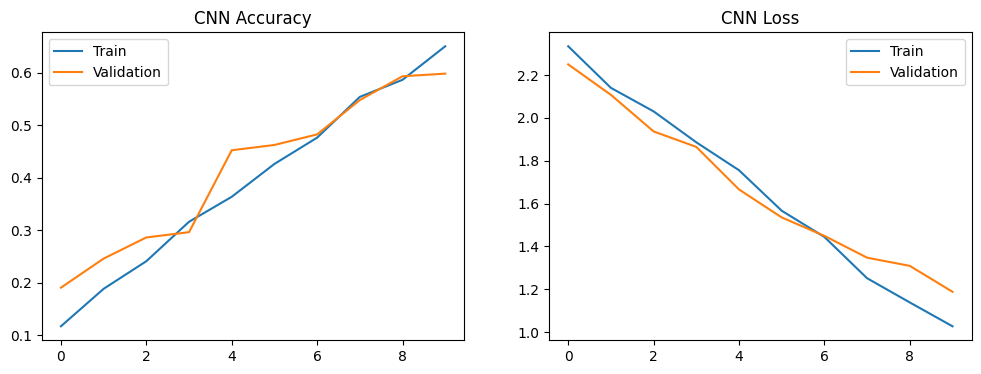

In [13]:
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('CNN Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('CNN Loss')
plt.legend()

plt.show()


10. Save Trained Models (RandomForest & CNN)

In [14]:
import pickle

# Save tabular model
pickle.dump(rf_model, open("music_genre_rf.pkl", "wb"))
pickle.dump(le, open("label_encoder.pkl", "wb"))
pickle.dump(scaler, open("scaler.pkl", "wb"))

# Save CNN model
cnn_model.save("music_genre_cnn.h5")


11. Install Streamlit & Other App Dependencies

In [15]:
!pip install -q streamlit kagglehub pyngrok scikit-learn pandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.2 MB/s eta 0:00:00


12. Create Streamlit App for Music Genre Classification

In [16]:
%%writefile music_genre_app.py
import streamlit as st
import pandas as pd
import numpy as np
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Page config
st.set_page_config(page_title="🎵 Music Genre Classifier", layout="centered")
st.title("🎼 Music Genre Classification App")
st.markdown("Predict the genre of a song using pre-extracted audio features (GTZAN dataset).")

# 📥 Load dataset
@st.cache_data
def load_data():
    path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")
    csv_path = path + "/Data/features_30_sec.csv"
    df = pd.read_csv(csv_path)
    return df

df = load_data()

# Show raw data
with st.expander("📂 View Raw Dataset"):
    st.dataframe(df.head())

# Prepare features
df = df.drop(columns=["filename"])
X = df.drop(columns=["label"])
y = df["label"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

with st.expander("📈 Model Evaluation"):
    st.write(f"**Accuracy:** {acc:.2%}")
    st.text("Classification Report:")
    st.text(classification_report(y_test, y_pred))
    st.text("Confusion Matrix:")
    st.text(confusion_matrix(y_test, y_pred))

# ---------------- User Input Form ----------------
st.header("🎤 Predict Genre from Features")

with st.form("genre_form"):
    col1, col2 = st.columns(2)
    input_features = []
    for i, col in enumerate(X.columns):
        if i % 2 == 0:
            val = col1.number_input(f"{col}", value=float(X[col].mean()))
        else:
            val = col2.number_input(f"{col}", value=float(X[col].mean()))
        input_features.append(val)

    submit = st.form_submit_button("Predict Genre")

# Prediction
if submit:
    input_array = np.array(input_features).reshape(1, -1)
    pred_genre = model.predict(input_array)[0]
    st.subheader("🎯 Prediction Result:")
    st.success(f"The predicted genre is: **{pred_genre}**")


Writing music_genre_app.py


13. Set Ngrok Authentication Token

In [17]:
from pyngrok import ngrok
ngrok.set_auth_token("YOUR_TOKEN_HERE")  # Replace with your token


14. Launch Streamlit App via Ngrok Tunnel

In [18]:
# Run Streamlit in background
!streamlit run music_genre_app.py &>/content/logs.txt &

# Create tunnel
public_url = ngrok.connect(addr=8501, proto="http")
print("🌍 App is live at:", public_url)


🌍 App is live at: NgrokTunnel: "https://8c364688131f.ngrok-free.app" -> "http://localhost:8501"
